In [1]:
from keras.layers import Input, Dense, Lambda, Layer, Multiply, Add, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt

Using TensorFlow backend.


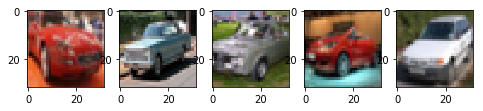

In [2]:
batch_size = 100
#original_dim = 784 #(28x28)
latent_dim = 16
intermediate_dim  = 576
epochs = 20

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

category = 1

x_train = x_train[y_train[:,0]==category,:,:] /255
y_train = y_train[y_train==category]
x_test = x_test[y_test[:,0]==category] /255
y_test = y_test[y_test==category]

fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[i])

In [3]:
class KLDivergenceLayer(Layer):
    #keras layerként jelenik meg

    """ 
    Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [ ]:
x = Input(shape=(32, 32, 3))

x1 = Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(x_test.shape,))(x)
x1 = Conv2D(128, (3, 3), padding="same", activation="relu", input_shape=(x_test.shape,))(x1)
x1 = Conv2D(256, (3, 3), padding="same", activation="relu", input_shape=(x_test.shape,))(x1)

x1 = Flatten()(x1)

# rejtett réteg
h = Dense(intermediate_dim, activation='relu')(x1)

# kimeneti réteg: átlag és a variancia logaritmusa
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0],latent_dim)))

z_eps = Multiply()([z_sigma,eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Reshape((np.sqrt(intermediate_dim),np.sqrt(intermediate_dim),1)),
    Conv2DTranspose(256, (3,3), activation='relu', padding='same'),
    Conv2DTranspose(128, (3,3), activation='relu', padding='same'),
    Conv2DTranspose(64, (3,3), activation='relu', padding='same'),
    Conv2DTranspose(3, (3,3), activation='relu', padding='same')
])

x_pred = decoder(z)

In [ ]:
def nll(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [ ]:
vae = Model(inputs=[x,eps], outputs=x_pred)

In [ ]:
vae.compile(optimizer='rmsprop',loss=nll)

In [ ]:
vae.summary()

In [ ]:
decoder.summary()

In [ ]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

In [ ]:
encoder = Model(x, z_mu)
encoder.summary()

In [ ]:
fig=plt.figure(figsize=(8, 6))
columns = 3
rows = 2

for i in range(1,7):
    z_sample = norm.ppf(np.random.rand(1,16))
    gen_image = decoder.predict(z_sample)
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_image.reshape(32,32,3))
plt.show()